# Imports

In [ ]:
# Import necessary modules / packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM, GRU, Conv1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform, HeNormal

from tensorflow.keras.models import load_model

from IPython.display import Image

# Dataset

In [ ]:
# Load the necessary dataset
weatherqc_dataset = pd.read_csv('weatherqc_dataset_final.csv')
weatherqc_dataset.head()

,time,temperature_2m (°C),relative_humidity_2m (%)
0,1940-01-02,22.724000,75.520000
1,1940-01-03,22.954167,77.166667
2,1940-01-04,23.533333,77.000000
3,1940-01-05,24.104167,79.000000
4,1940-01-06,24.145833,83.666667


In [ ]:
weatherqc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30821 entries, 0 to 30820
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      30821 non-null  object 
 1   temperature_2m (°C)       30821 non-null  float64
 2   relative_humidity_2m (%)  30821 non-null  float64
dtypes: float64(2), object(1)
memory usage: 722.5+ KB


In [ ]:
weatherqc_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature_2m (°C),30821.0,26.208763,1.451434,20.816667,25.295833,26.137500,27.062500,32.733333
relative_humidity_2m (%),30821.0,79.419437,7.419842,51.583333,73.916667,80.208333,85.166667,96.291667


In [ ]:
weatherqc_dataset.index = pd.to_datetime(weatherqc_dataset['time'])

<Axes: xlabel='time'>

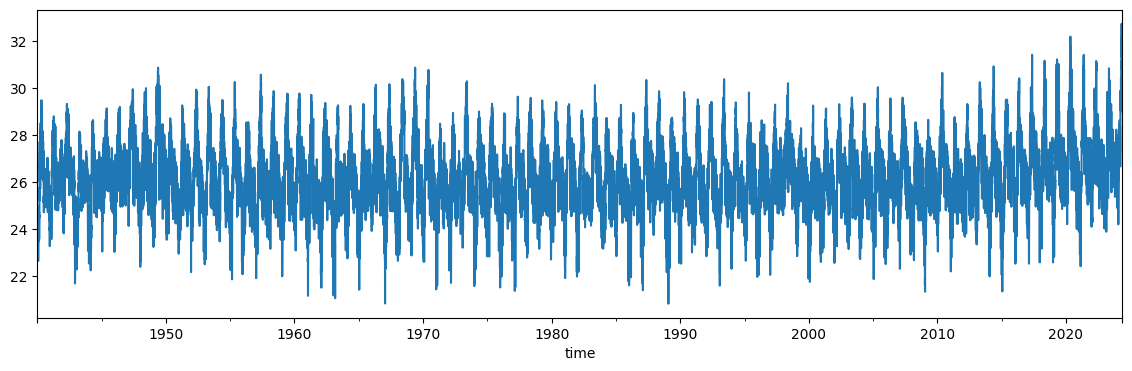

In [ ]:
# Graph of temperature vs time
temp = weatherqc_dataset['temperature_2m (°C)']
temp.plot(figsize=(14, 4))

<Axes: xlabel='time'>

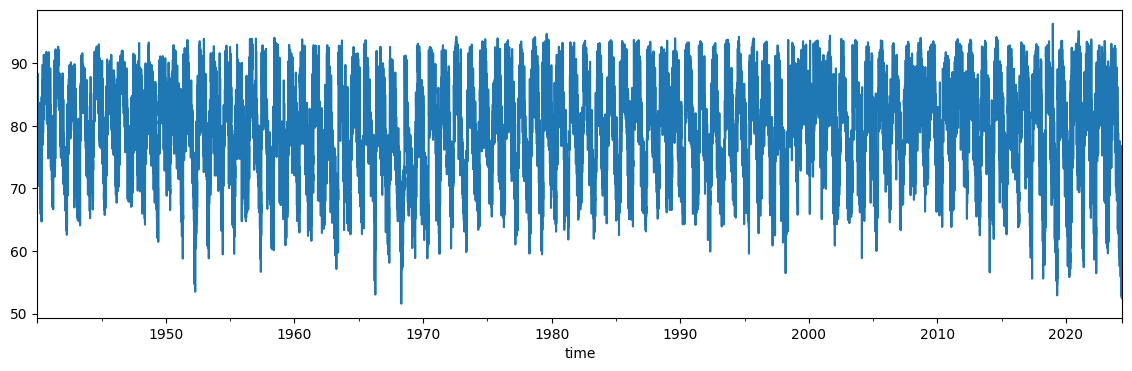

In [ ]:
# Graph of Relative Humidity vs time
rel_humidity = weatherqc_dataset['relative_humidity_2m (%)']
rel_humidity.plot(figsize=(14, 4))

# Data Preprocessing

In [ ]:
# Create a new dataframe containing temperature and relative humidity
rh_hi_df = pd.DataFrame({'Temperature': temp, 'Relative Humidity': rel_humidity})
rh_hi_df.head()

,Temperature,Relative Humidity
time,,
1940-01-02,22.724000,75.520000
1940-01-03,22.954167,77.166667
1940-01-04,23.533333,77.000000
1940-01-05,24.104167,79.000000
1940-01-06,24.145833,83.666667


In [ ]:
# Add sin and cosine signals column to the dataframe
# Ginawa sa tutorial (feature engineering purposes), additional reference https://ai.stackexchange.com/questions/30442/why-use-sin-cos-to-give-periodicity-in-time-series-prediction

# If we want to add time as feature variable

day = 60*60*24
year = 365.2425*day

rh_hi_df['Seconds'] = rh_hi_df.index.map(pd.Timestamp.timestamp)
rh_hi_df['Year sin'] = np.sin(rh_hi_df['Seconds'] * (2 * np.pi / year))
rh_hi_df['Year cos'] = np.cos(rh_hi_df['Seconds'] * (2 * np.pi / year))
rh_hi_df = rh_hi_df.drop('Seconds', axis=1)
# rh_hi_df.head()

# Create sequences and labels

In [ ]:
'''
Define a function for creating sequences and labels
Sequences consist of [[t1, rh1], [t2, rh2], [t3, rh3], [t4, rh4], [t5, rh5], [t6, rh6], [t7, rh7]
Sequences consist of [[t2, rh2], [t3, rh3], [t4, rh4], [t5, rh5], [t6, rh6], [t7, rh7], [t8, rh8]
                     [[..3, ..3], [..4, ..4], [..5, ..5], [..6, ..6], [..7, ..7], [..8, ..8], [..9, ..9]]

Labels consist of [[t8, rh8]]
Labels consist of [[t9, rh9]]
                  [[..., ...]]
'''

def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X, y = df_to_X_y(rh_hi_df)
X.shape, y.shape

((30814, 7, 4), (30814, 2))

# Train/test split

In [ ]:
# Train-val-test split 50-25-25
X_train, y_train = X[:15407], y[:15407]
X_val, y_val = X[15408:23110], y[15408:23110]
X_test, y_test = X[23111:], y[23111:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15407, 7, 4), (15407, 2), (7702, 7, 4), (7702, 2), (7703, 7, 4), (7703, 2))

In [ ]:
'''
Define functions for preprocessing
Standardize the dataset due to large value difference between temperature and relative humidity to year sin and year cos
Standardize both X and y
'''

temp_training_mean = np.mean(X_train[:, :, 0])
temp_training_std = np.std(X_train[:, :, 0])

rel_humidity_training_mean = np.mean(X_train[:, :, 1])
rel_humidity_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  X[:, :, 1] = (X[:, :, 1] - rel_humidity_training_mean) / rel_humidity_std

def preprocess_output(y):
  y[:, 0] = (y[:, 0] - temp_training_mean) / temp_training_std
  y[:, 1] = (y[:, 1] - rel_humidity_training_mean) / rel_humidity_std
  return y

print(temp_training_mean, temp_training_std, rel_humidity_training_mean, rel_humidity_std)

26.116603739441366 1.45009497436384 78.9618651836504 7.3271595730319286


In [ ]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

In [ ]:
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

array([[ 2.08036691, -1.84294224],
       [ 1.9769254 , -1.37664058],
       [ 1.81314303, -0.95014516],
       ...,
       [ 2.15794803, -0.33599175],
       [ 1.98267215, -0.30755872],
       [ 2.45965241, -0.72836754]])

# Data Postprocessing

In [ ]:
# Postprocess the data to obtain actual values
def postprocess_temp(arr):
  print(f"temp before postprocess:{arr}")
  arr = (arr*temp_training_std) + temp_training_mean
  print(f"temp after postprocess:{arr}")
  return arr

def postprocess_rh(arr):
  arr = (arr*rel_humidity_std) + rel_humidity_training_mean
  return arr

In [ ]:
# Plot the predictions vs actuals using postprocessed data
def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  rel_humidity_preds, temp_preds = postprocess_rh(predictions[:, 0]), postprocess_temp(predictions[:, 1])
  rel_humidity_actuals, temp_actuals = postprocess_rh(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals': temp_actuals,
                          'Relative Humidity Predictions': rel_humidity_preds,
                          'Relative Humidity Actuals': rel_humidity_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Relative Humidity Predictions'][start:end])
  plt.plot(df['Relative Humidity Actuals'][start:end])
  return df[start:end]

# LSTM

In [ ]:
# Create LSTM Model
lstm_model = Sequential()
lstm_model.add(InputLayer((7, 4)))  # 7 for window size, 4 for number of variables (app temp, rel hum, year sin, year cos)

lstm_model.add(LSTM(units=128))

lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(2, 'linear'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 69146 (270.10 KB)
Trainable params: 69146 (270.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cp5 = ModelCheckpoint('lstm_model.keras', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001, clipnorm=1.), metrics=[RootMeanSquaredError()])

## Train

In [ ]:
# Train the LSTM Model
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[early_stopping, cp5])

Epoch 1/200
482/482 [==============================] - 11s 18ms/step - loss: 0.4556 - root_mean_squared_error: 0.6750 - val_loss: 0.2423 - val_root_mean_squared_error: 0.4923
Epoch 2/200
482/482 [==============================] - 6s 13ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832 - val_loss: 0.2100 - val_root_mean_squared_error: 0.4583
Epoch 3/200
482/482 [==============================] - 8s 16ms/step - loss: 0.1972 - root_mean_squared_error: 0.4441 - val_loss: 0.1888 - val_root_mean_squared_error: 0.4345
Epoch 4/200
482/482 [==============================] - 6s 13ms/step - loss: 0.1719 - root_mean_squared_error: 0.4146 - val_loss: 0.1620 - val_root_mean_squared_error: 0.4024
Epoch 5/200
482/482 [==============================] - 8s 17ms/step - loss: 0.1560 - root_mean_squared_error: 0.3950 - val_loss: 0.1502 - val_root_mean_squared_error: 0.3876
Epoch 6/200
482/482 [==============================] - 6s 13ms/step - loss: 0.1454 - root_mean_squared_error: 0.3813 - val_loss: 

## Predictions

482/482 [==============================] - 3s 4ms/step
temp before postprocess:[ 0.7367969   0.8686634   0.1416086  ... -0.71805227 -0.9441462
 -1.2504756 ]
temp after postprocess:[27.18503  27.376247 26.321949 ... 25.07536  24.747501 24.303295]
temp before postprocess:[ 1.27900424  0.51131248 -0.34167836 ... -0.80229341 -1.25722186
 -1.31977452]
temp after postprocess:[27.97128136 26.8580554  25.62113767 ... 24.9532021  24.29351264
 24.20280534]


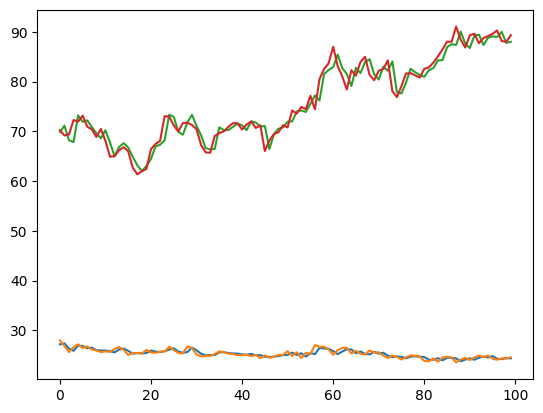

In [ ]:
# Prediction vs Actual graph using trained data for temperature and relative humidity
post_train_processed_df = plot_predictions(lstm_model, X_train, y_train)
post_train_processed_df.to_csv('LSTM Train Temp & RH.csv')

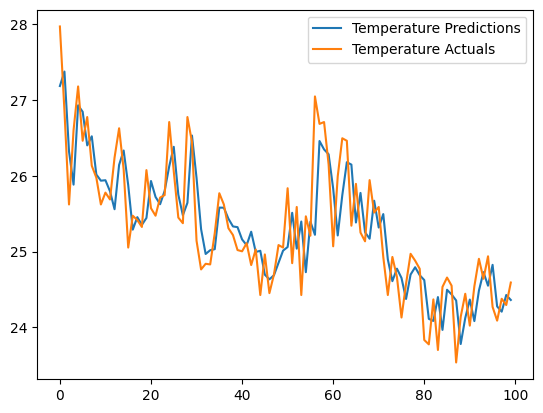

In [ ]:
# Prediction vs Actual graph using trained data for temperature only shown
start, end = 0, 100
plt.plot(post_train_processed_df['Temperature Predictions'][start:end])
plt.plot(post_train_processed_df['Temperature Actuals'][start:end])
plt.legend(['Temperature Predictions', 'Temperature Actuals'], loc='upper right')

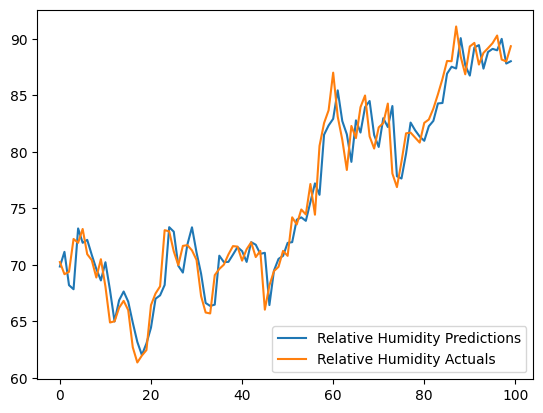

In [ ]:
# Prediction vs Actual graph using trained data for relative humidity only shown
plt.plot(post_train_processed_df['Relative Humidity Predictions'][start:end])
plt.plot(post_train_processed_df['Relative Humidity Actuals'][start:end])
plt.legend(['Relative Humidity Predictions', 'Relative Humidity Actuals'], loc='lower right')

241/241 [==============================] - 1s 4ms/step
temp before postprocess:[-1.5745549  -1.7068853  -1.4144573  ... -0.24733299 -0.3133914
 -0.23391819]
temp after postprocess:[23.83335  23.641459 24.065506 ... 25.757948 25.662157 25.777401]
temp before postprocess:[-1.84294224 -1.37664058 -0.95014516 ... -0.33599175 -0.30755872
 -0.72836754]
temp after postprocess:[23.44416246 24.12034416 24.73880302 ... 25.62938379 25.67061438
 25.06040163]


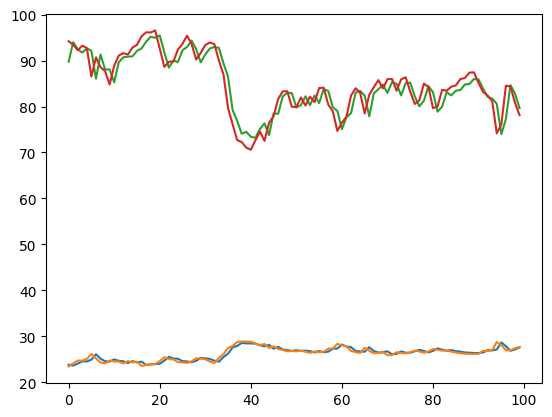

In [ ]:
# Prediction vs Actual graph using test data for temperature and relative humidity
post_test_processed_df = plot_predictions(lstm_model, X_test, y_test)
post_test_processed_df.to_csv('LSTM Test Temp & RH.csv')

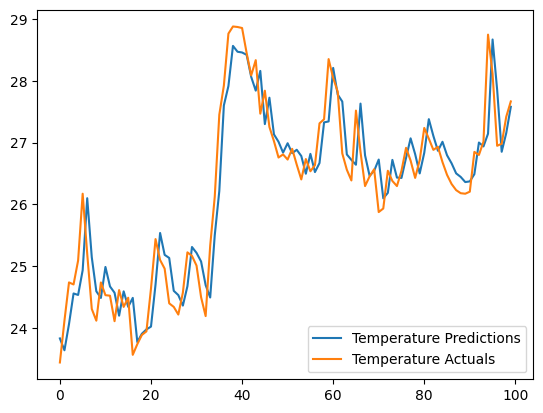

In [ ]:
# Prediction vs Actual graph using test data for temperature only shown
start, end = 0, 100
plt.plot(post_test_processed_df['Temperature Predictions'][start:end])
plt.plot(post_test_processed_df['Temperature Actuals'][start:end])
plt.legend(['Temperature Predictions', 'Temperature Actuals'], loc='lower right')

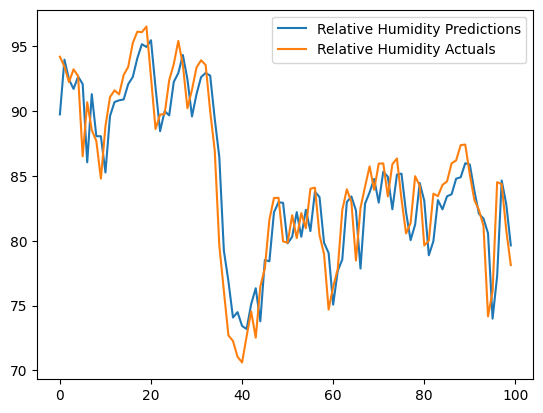

In [ ]:
# Prediction vs Actual graph using test data for relative humidity only shown
plt.plot(post_test_processed_df['Relative Humidity Predictions'][start:end])
plt.plot(post_test_processed_df['Relative Humidity Actuals'][start:end])
plt.legend(['Relative Humidity Predictions', 'Relative Humidity Actuals'], loc='upper right')

In [ ]:
def calculate_metrics(y_true, y_pred):
    # Mean Absolute Error
    mae_ = mae(y_true, y_pred)

    # Mean Squared Error
    mse_ = mse(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse_)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # R2 score
    r2 = r2_score(y_true, y_pred)

    return mae_, mse_, rmse, mape, r2

## Metrics

In [ ]:
lstm_temp_train_mae, lstm_temp_train_mse, lstm_temp_train_rmse, lstm_temp_train_mape, lstm_temp_train_r2 = calculate_metrics(post_train_processed_df['Temperature Actuals'], post_train_processed_df['Temperature Predictions'])
lstm_temp_test_mae, lstm_temp_test_mse, lstm_temp_test_rmse, lstm_temp_test_mape, lstm_temp_test_r2 = calculate_metrics(post_test_processed_df['Temperature Actuals'], post_test_processed_df['Temperature Predictions'])

lstm_rh_train_mae, lstm_rh_train_mse,lstm_rh_train_rmse, lstm_rh_train_mape, lstm_rh_train_r2 = calculate_metrics(post_train_processed_df['Relative Humidity Actuals'], post_train_processed_df['Relative Humidity Predictions'])
lstm_rh_test_mae, lstm_rh_test_mse, lstm_rh_test_rmse, lstm_rh_test_mape, lstm_rh_test_r2 = calculate_metrics(post_test_processed_df['Relative Humidity Actuals'], post_test_processed_df['Relative Humidity Predictions'])

print("Metrics:\t\t\t\tMAE\t\t\tMSE\t\t\tRMSE\t\t\tMAPE\t\t\tR2\n")

print(f"Train Temperature Metrics:\t\t{lstm_temp_train_mae}\t{lstm_temp_train_mse}\t{lstm_temp_train_rmse}\t{lstm_temp_train_mape}\t{lstm_temp_train_r2}")
print(f"Test Temperature Metrics:\t\t{lstm_temp_test_mae}\t{lstm_temp_test_mse}\t{lstm_temp_test_rmse}\t{lstm_temp_test_mape}\t{lstm_temp_test_r2}")
print()
print(f"Train Relative Humidity Metrics:\t{lstm_rh_train_mae}\t{lstm_rh_train_mse}\t{lstm_rh_train_rmse}\t{lstm_rh_train_mape}\t{lstm_rh_train_r2}")
print(f"Test Relative Humidity Metrics:\t\t{lstm_rh_test_mae}\t{lstm_rh_test_mse}\t{lstm_rh_test_rmse}\t{lstm_rh_test_mape}\t{lstm_rh_test_r2}")


Metrics:				MAE			MSE			RMSE			MAPE			R2

Train Temperature Metrics:		0.3803582109145707	0.23280879876500063	0.48250264120002556	1.4971964551654697	0.6850833780646097
Test Temperature Metrics:		0.3919626475929972	0.246379104302227	0.4963658976019878	1.4961537020535067	0.8717329278255312

Train Relative Humidity Metrics:	1.442177933612685	3.471196392203693	1.8631147018376761	1.8988580455778135	0.9477692112728602
Test Relative Humidity Metrics:		2.048941357107706	6.487292852401502	2.5470164609600587	2.456732316639652	0.8432024334220694


## Evaluation

In [ ]:
# Evaluate the best model on the test set
lstm_best_model = load_model('lstm_model.keras')
lstm_test_loss = lstm_best_model.evaluate(X_test, y_test)
print("Test Loss of LSTM Model:", lstm_test_loss)

241/241 [==============================] - 2s 7ms/step - loss: 0.1593 - root_mean_squared_error: 0.3991
Test Loss of LSTM Model: [0.15927006304264069, 0.39908653497695923]


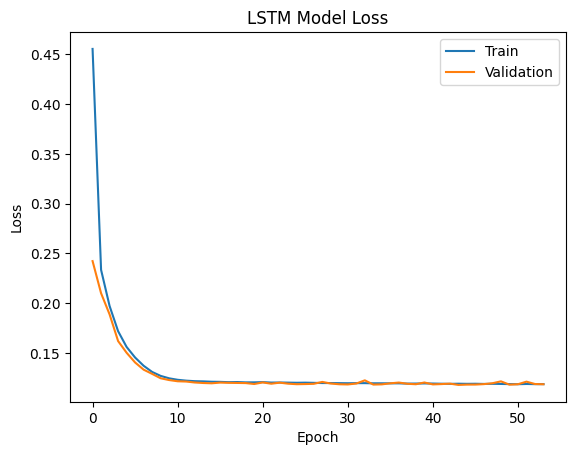

In [ ]:
# Plot model training & validation loss values
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Heat index function, computes the heat index given temperature and relative humidity
import math

def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

def heat_index_celsius(temperature_celsius, relative_humidity):

    temperature = celsius_to_fahrenheit(temperature_celsius)

    # Simple formula calculation
    hi_simple = 0.5 * (temperature + 61.0 + ((temperature - 68.0) * 1.2) + (relative_humidity * 0.094))

    # Check if simple formula result is 80 degrees F or higher
    if hi_simple >= 80:
        # Full Rothfusz regression equation with adjustments

        # Rothfusz regression equation
        hi = (-42.379 +
              2.04901523 * temperature +
              10.14333127 * relative_humidity -
              0.22475541 * temperature * relative_humidity -
              0.00683783 * temperature**2 -
              0.05481717 * relative_humidity**2 +
              0.00122874 * temperature**2 * relative_humidity +
              0.00085282 * temperature * relative_humidity**2 -
              0.00000199 * temperature**2 * relative_humidity**2)

        # Adjustment for RH < 13% and 80 <= T <= 112
        if relative_humidity < 13 and temperature >= 80 and temperature <= 112:
            adjustment = ((13 - relative_humidity) / 4) * math.sqrt((17 - abs(temperature - 95.0)) / 17)
            hi -= adjustment

        # Adjustment for RH > 85% and 80 <= T <= 87
        elif relative_humidity > 85 and temperature >= 80 and temperature <= 87:
            adjustment = ((relative_humidity - 85) / 10) * ((87 - temperature) / 5)
            hi += adjustment

        return (hi - 32) * 5/9

    else:
        return (hi_simple - 32) * 5/9

def is_RH_over_hundred(RH):
  if RH >= 100:
    return 100
  else:
    return RH



# Application

In [ ]:
'''
Try on user inputs
'''
import datetime

saved_lstm_model = load_model('lstm_model.keras')

heat_indices = []
forecast_temp = []
forecast_rel_hum = []

date_str = '2024-05-20' # user input date today

date_object = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
# print(type(date_object))
# print(date_object)  # printed in default format

def generate_epoch_times(given_date):
    # List to store the epoch times
    epoch_times = []

    # Iterate over the range of days from 7 days before to 6 days after the given date
    for i in range(-7, 7):
        # Calculate the current date in the range
        current_date = given_date + datetime.timedelta(days=i)
        # Convert the date to a datetime object at midnight
        datetime_obj = datetime.datetime.combine(current_date, datetime.datetime.min.time())
        # Calculate the epoch time (seconds since the epoch)
        epoch_time = (datetime_obj - datetime.datetime(1970, 1, 1)).total_seconds()
        # Append the epoch time to the list
        epoch_times.append(epoch_time)

    return epoch_times

# Generate the list of epoch times
epoch_times_list = generate_epoch_times(date_object)

# temp_inputs = [37.7, 35.8, 37.8, 35.7, 34.4, 37, 33.9]  # try other inputs
# RH_inputs = [33, 44, 37, 44, 52, 41, 56]  # try other inputs
temp_inputs = [0, 0, 0, 0, 0, 0, 0]  # try other inputs
RH_inputs = [0, 0, 0, 0, 0, 0, 0]  # try other inputs
year_sin = [np.sin(2 * np.pi * i / (365.2425 * 24 * 3600)) for i in epoch_times_list]
year_cos = [np.cos(2 * np.pi * i / (365.2425 * 24 * 3600)) for i in epoch_times_list]

user_input_past_temp = np.array([
    [temp_inputs[6], RH_inputs[6], year_sin[0], year_cos[0]],
    [temp_inputs[5], RH_inputs[5], year_sin[1], year_cos[1]],
    [temp_inputs[4], RH_inputs[4] ,year_sin[2], year_cos[2]],
    [temp_inputs[3], RH_inputs[3] ,year_sin[3], year_cos[3]],
    [temp_inputs[2], RH_inputs[2], year_sin[4], year_cos[4]],
    [temp_inputs[1], RH_inputs[1], year_sin[5], year_cos[5]],
    [temp_inputs[0], RH_inputs[0], year_sin[6], year_cos[6]]]).reshape(1, 7, 4)

for i in range(7):
  # predictions = saved_lstm_model.predict(user_input_past_temp)
  # temp_and_rel_hum = predictions[0][:]
  # temperature = postprocess_temp(temp_and_rel_hum[0])
  # relative_humidity = is_RH_over_hundred(postprocess_rh(temp_and_rel_hum[1]))
  # forecast_temp.append(temperature)
  # forecast_rel_hum.append(relative_humidity)
  # prediction = np.append(np.append(predictions[0][:], np.array(year_sin[i+7])), np.array(year_cos[i+7]))  # add year sin and year cos
  # heat_indices.append(heat_index_celsius(temperature, relative_humidity))
  # user_input_past_temp = np.delete(user_input_past_temp, 0, axis=1)
  # user_input_past_temp = np.append(user_input_past_temp, prediction).reshape(1, 7, 4)

            predictions = saved_lstm_model(user_input_past_temp, training=False)
            app_temp_and_rel_hum = predictions[0].numpy()
            apparent_temperature = postprocess_temp(app_temp_and_rel_hum[0])
            relative_humidity = postprocess_rh(app_temp_and_rel_hum[1])
            forecast_temp.append(apparent_temperature)
            forecast_rel_hum.append(relative_humidity)
            prediction = np.array([app_temp_and_rel_hum[0], app_temp_and_rel_hum[1], year_sin[i + 7], year_cos[i + 7]])
            heat_indices.append(heat_index_celsius(apparent_temperature, relative_humidity))
            user_input_past_temp = np.delete(user_input_past_temp, 0, axis=1)
            user_input_past_temp = np.append(user_input_past_temp, prediction).reshape(1, 7, 4)
# print(f'Temperature for the next seven days: {heat_indices}')
print()
print("Heat Index Forecast: \t \t", heat_indices)
print("Temperature Forecast:\t\t", forecast_temp)
print("Relative Humidity Forecast: \t", forecast_rel_hum)
print()
# print(user_input_past_temp)


# Observation: (try on inputs)
# 2-day HI Forecast seems okay (~ ±2 C)
# 3-day onwards not so much
# PAGASA uses 5-day computed and 2-day forecast
# Our model uses 7-day and 7-day forecast

temp before postprocess:0.10082191228866577
temp after postprocess:26.262805087756913
temp before postprocess:0.1938612014055252
temp after postprocess:26.397720893323655
temp before postprocess:0.26434773206710815
temp after postprocess:26.49993305719636
temp before postprocess:0.3161506652832031
temp after postprocess:26.575052230310323
temp before postprocess:0.3543090522289276
temp after postprocess:26.63038551545015
temp before postprocess:0.3828630745410919
temp after postprocess:26.671791559702893
temp before postprocess:0.4048120379447937
temp after postprocess:26.703619641227096

Heat Index Forecast: 	 	 [28.132022899654032, 28.399034727542748, 28.60541808130095, 28.76073347061654, 28.878748751937948, 28.971026687722908, 29.046430033180755]
Temperature Forecast:		 [26.262805087756913, 26.397720893323655, 26.49993305719636, 26.575052230310323, 26.63038551545015, 26.671791559702893, 26.703619641227096]
Relative Humidity Forecast: 	 [79.01774273615922, 79.03258471630807, 79.05236

In [ ]:
def heat_index_classification(index):
  """
  Takes in index (element from forecast_temp list)
  Outputs NWS classification
  """
  if 27 <= index < 33:
    return 'CAUTION'
  elif 33 <= index < 40:
    return 'EXTREME CAUTION'
  elif 40 <= index < 52:
    return 'DANGER'
  elif index >= 52:
    return 'EXTREME DANGER'

In [ ]:
for i in heat_indices:
  print(f"{i:,.2f}", heat_index_classification(i))

28.13 CAUTION
28.40 CAUTION
28.61 CAUTION
28.76 CAUTION
28.88 CAUTION
28.97 CAUTION
29.05 CAUTION


# Conv1d

In [ ]:
# Create Conv1d model
conv1d_model = Sequential()
conv1d_model.add(InputLayer((7, 4)))
conv1d_model.add(Conv1D(64, kernel_size=3, activation='relu'))
conv1d_model.add(Dropout(0.00025)) #0.1, 0.05, 0.2
conv1d_model.add(Flatten())
conv1d_model.add(Dense(8, 'relu'))
conv1d_model.add(Dense(2, 'linear'))

conv1d_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             832       
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2568      
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 3418 (13.35 KB)
Trainable params: 3418 (13.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #detect if di na nagbabago
cp5 = ModelCheckpoint('conv1d_model.keras', save_best_only=True)
conv1d_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001, clipnorm=1.), metrics=[RootMeanSquaredError()])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## Train

In [ ]:
# Train the Conv1d Model
conv1d_history = conv1d_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping, cp5, reduce_lr])

Epoch 1/100
482/482 [==============================] - 2s 3ms/step - loss: 0.4220 - root_mean_squared_error: 0.6496 - val_loss: 0.2294 - val_root_mean_squared_error: 0.4789 - lr: 1.0000e-04
Epoch 2/100
482/482 [==============================] - 1s 3ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592 - val_loss: 0.1887 - val_root_mean_squared_error: 0.4344 - lr: 1.0000e-04
Epoch 3/100
482/482 [==============================] - 1s 3ms/step - loss: 0.1775 - root_mean_squared_error: 0.4213 - val_loss: 0.1628 - val_root_mean_squared_error: 0.4035 - lr: 1.0000e-04
Epoch 4/100
482/482 [==============================] - 1s 3ms/step - loss: 0.1559 - root_mean_squared_error: 0.3948 - val_loss: 0.1481 - val_root_mean_squared_error: 0.3849 - lr: 1.0000e-04
Epoch 5/100
482/482 [==============================] - 1s 3ms/step - loss: 0.1433 - root_mean_squared_error: 0.3785 - val_loss: 0.1389 - val_root_mean_squared_error: 0.3727 - lr: 1.0000e-04
Epoch 6/100
482/482 [=============================

## Predictions

482/482 [==============================] - 1s 1ms/step
temp before postprocess:[ 0.7719516   0.80173033  0.09984771 ... -0.7040515  -0.93047065
 -1.3042006 ]
temp after postprocess:[27.236008 27.279188 26.261393 ... 25.095663 24.767334 24.22539 ]
temp before postprocess:[ 1.27900424  0.51131248 -0.34167836 ... -0.80229341 -1.25722186
 -1.31977452]
temp after postprocess:[27.97128136 26.8580554  25.62113767 ... 24.9532021  24.29351264
 24.20280534]


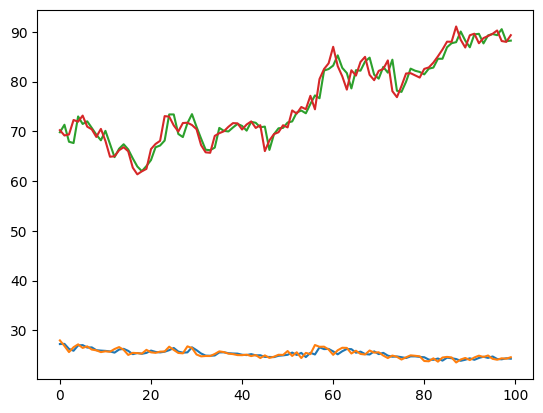

In [ ]:
# Prediction vs Actual graph using trained data for temperature and relative humidity
post_conv1dtrain_processed_df = plot_predictions(conv1d_model, X_train, y_train)
post_conv1dtrain_processed_df.to_csv('Conv1D Train temp & RH.csv')

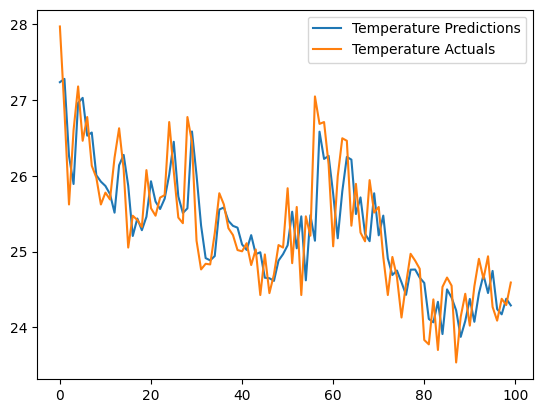

In [ ]:
# Prediction vs Actual graph using trained data for temperature only shown
start, end = 0, 100
plt.plot(post_conv1dtrain_processed_df['Temperature Predictions'][start:end])
plt.plot(post_conv1dtrain_processed_df['Temperature Actuals'][start:end])
plt.legend(['Temperature Predictions', 'Temperature Actuals'], loc='upper right')

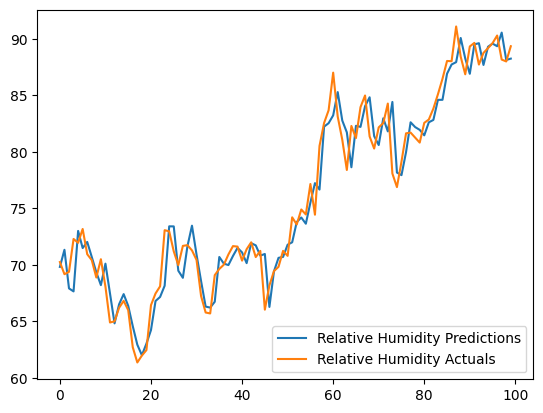

In [ ]:
# Prediction vs Actual graph using trained data for relative humidity only shown
plt.plot(post_conv1dtrain_processed_df['Relative Humidity Predictions'][start:end])
plt.plot(post_conv1dtrain_processed_df['Relative Humidity Actuals'][start:end])
plt.legend(['Relative Humidity Predictions', 'Relative Humidity Actuals'], loc='lower right')

241/241 [==============================] - 0s 1ms/step
temp before postprocess:[-1.5784831  -1.640763   -1.4549277  ... -0.2623218  -0.32828045
 -0.22655089]
temp after postprocess:[23.827654 23.73734  24.00682  ... 25.736212 25.640566 25.788084]
temp before postprocess:[-1.84294224 -1.37664058 -0.95014516 ... -0.33599175 -0.30755872
 -0.72836754]
temp after postprocess:[23.44416246 24.12034416 24.73880302 ... 25.62938379 25.67061438
 25.06040163]


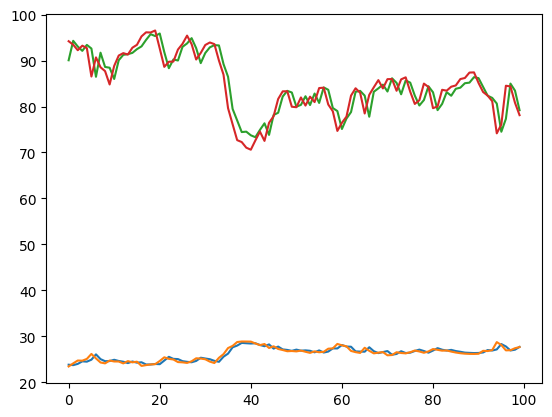

In [ ]:
# Prediction vs Actual graph using test data for temperature and relative humidity
post_conv1dtest_processed_df = plot_predictions(conv1d_model, X_test, y_test)
post_conv1dtest_processed_df.to_csv('Conv1D Test temp & RH.csv')

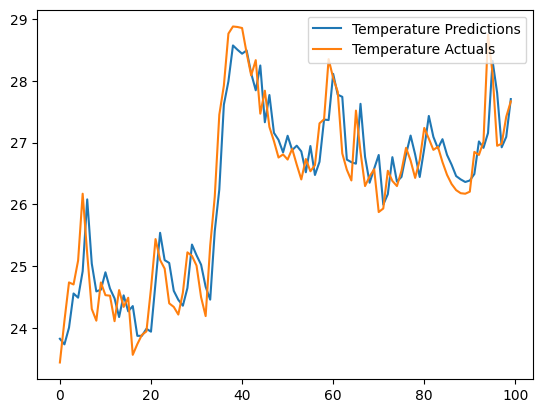

In [ ]:
# Prediction vs Actual graph using trained data for temperature only shown
start, end = 0, 100
plt.plot(post_conv1dtest_processed_df['Temperature Predictions'][start:end])
plt.plot(post_conv1dtest_processed_df['Temperature Actuals'][start:end])
plt.legend(['Temperature Predictions', 'Temperature Actuals'], loc='upper right')

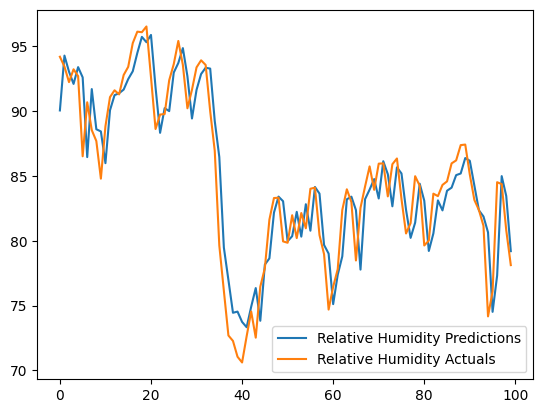

In [ ]:
# Prediction vs Actual graph using trained data for relative humidity only shown
plt.plot(post_conv1dtest_processed_df['Relative Humidity Predictions'][start:end])
plt.plot(post_conv1dtest_processed_df['Relative Humidity Actuals'][start:end])
plt.legend(['Relative Humidity Predictions', 'Relative Humidity Actuals'], loc='lower right')

## Metrics

In [ ]:
conv1d_temp_train_mae, conv1d_temp_train_mse, conv1d_temp_train_rmse, conv1d_temp_train_mape, conv1d_temp_train_r2 = calculate_metrics(post_conv1dtrain_processed_df['Temperature Actuals'], post_conv1dtrain_processed_df['Temperature Predictions'])
conv1d_temp_test_mae, conv1d_temp_test_mse, conv1d_temp_test_rmse, conv1d_temp_test_mape, conv1d_temp_test_r2 = calculate_metrics(post_conv1dtest_processed_df['Temperature Actuals'], post_conv1dtest_processed_df['Temperature Predictions'])

conv1d_rh_train_mae, conv1d_rh_train_mse, conv1d_rh_train_rmse, conv1d_rh_train_mape, conv1d_rh_train_r2 = calculate_metrics(post_conv1dtrain_processed_df['Relative Humidity Actuals'], post_conv1dtrain_processed_df['Relative Humidity Predictions'])
conv1d_rh_test_mae, conv1d_rh_test_mse, conv1d_rh_test_rmse, conv1d_rh_test_mape, conv1d_rh_test_r2 = calculate_metrics(post_conv1dtest_processed_df['Relative Humidity Actuals'], post_conv1dtest_processed_df['Relative Humidity Predictions'])

print("Metrics:\t\t\t\tMAE\t\t\tMSE\t\t\tRMSE\t\t\tMAPE\t\t\tR2\n")

print(f"Train Temperature Metrics:\t\t{conv1d_temp_train_mae}\t{conv1d_temp_train_mse}\t{conv1d_temp_train_rmse}\t{conv1d_temp_train_mape}\t{conv1d_temp_train_r2}")
print(f"Test Temperature Metrics:\t\t{conv1d_temp_test_mae}\t{conv1d_temp_test_mse}\t{conv1d_temp_test_rmse}\t{conv1d_temp_test_mape}\t{conv1d_temp_test_r2}")
print()
print(f"Train Relative Humidity Metrics:\t{conv1d_rh_train_mae}\t{conv1d_rh_train_mse}\t{conv1d_rh_train_rmse}\t{conv1d_rh_train_mape}\t{conv1d_rh_train_r2}")
print(f"Test Relative Humidity Metrics:\t\t{conv1d_rh_test_mae}\t{conv1d_rh_test_mse}\t{conv1d_rh_test_rmse}\t{conv1d_rh_test_mape}\t{conv1d_rh_test_r2}")


Metrics:				MAE			MSE			RMSE			MAPE			R2

Train Temperature Metrics:		0.38103491517479776	0.23845748373303202	0.48832108671757357	1.4988943425343169	0.6774424950827544
Test Temperature Metrics:		0.3814695130044068	0.238622542859272	0.48849006423802727	1.4554633078440269	0.8757710601551657

Train Relative Humidity Metrics:	1.407276917437025	3.4477145014143673	1.8568022246363147	1.8561277214286014	0.9481225412312243
Test Relative Humidity Metrics:		1.9756759952041552	6.295745218830746	2.5091323637526073	2.3776154665064233	0.8478321308183473


## Evaluation

241/241 [==============================] - 0s 2ms/step - loss: 0.1578 - root_mean_squared_error: 0.3973
Test Loss of Conv1d Model: [0.157821387052536, 0.3972674012184143]


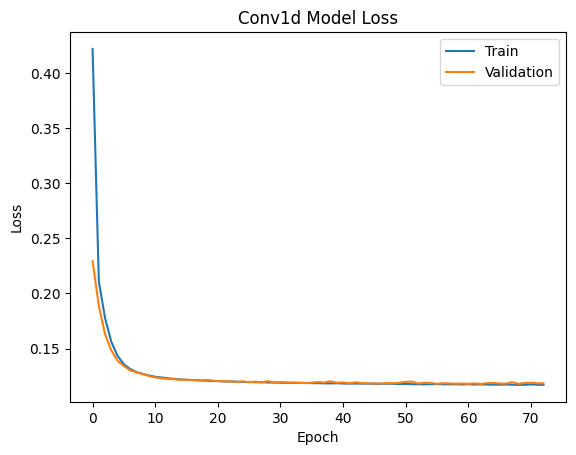

In [ ]:
# Evaluate the best model on the test set
conv1d_best_model = load_model('conv1d_model.keras')
conv1d_test_loss = conv1d_best_model.evaluate(X_test, y_test)
print("Test Loss of Conv1d Model:", conv1d_test_loss)

# Plot model training & validation loss values
plt.plot(conv1d_history.history['loss'])
plt.plot(conv1d_history.history['val_loss'])
plt.title('Conv1d Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# GRU

In [ ]:
gru_model = Sequential()
gru_model.add(InputLayer((7, 4)))
gru_model.add(GRU(128))
gru_model.add(Dense(8, 'relu'))
gru_model.add(Dense(2, 'linear'))
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51456     
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 52506 (205.10 KB)
Trainable params: 52506 (205.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #detect if di na nagbabago
cp5 = ModelCheckpoint('gru_model.keras', save_best_only=True)
gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001, clipnorm=1), metrics=[RootMeanSquaredError()])

## Train

In [ ]:
# Train the GRU Model
gru_history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[early_stopping, cp5])

Epoch 1/200
482/482 [==============================] - 10s 15ms/step - loss: 0.3613 - root_mean_squared_error: 0.6011 - val_loss: 0.1950 - val_root_mean_squared_error: 0.4416
Epoch 2/200
482/482 [==============================] - 5s 11ms/step - loss: 0.1826 - root_mean_squared_error: 0.4274 - val_loss: 0.1635 - val_root_mean_squared_error: 0.4044
Epoch 3/200
482/482 [==============================] - 6s 13ms/step - loss: 0.1568 - root_mean_squared_error: 0.3959 - val_loss: 0.1455 - val_root_mean_squared_error: 0.3814
Epoch 4/200
482/482 [==============================] - 5s 10ms/step - loss: 0.1424 - root_mean_squared_error: 0.3773 - val_loss: 0.1360 - val_root_mean_squared_error: 0.3687
Epoch 5/200
482/482 [==============================] - 5s 10ms/step - loss: 0.1336 - root_mean_squared_error: 0.3655 - val_loss: 0.1286 - val_root_mean_squared_error: 0.3586
Epoch 6/200
482/482 [==============================] - 6s 13ms/step - loss: 0.1282 - root_mean_squared_error: 0.3580 - val_loss: 

## Predictions


482/482 [==============================] - 2s 3ms/step
temp before postprocess:[ 0.71044034  0.8509452   0.12987483 ... -0.73644197 -0.9535782
 -1.2731574 ]
temp after postprocess:[27.14681  27.350555 26.304935 ... 25.048693 24.733826 24.270405]
temp before postprocess:[ 1.27900424  0.51131248 -0.34167836 ... -0.80229341 -1.25722186
 -1.31977452]
temp after postprocess:[27.97128136 26.8580554  25.62113767 ... 24.9532021  24.29351264
 24.20280534]


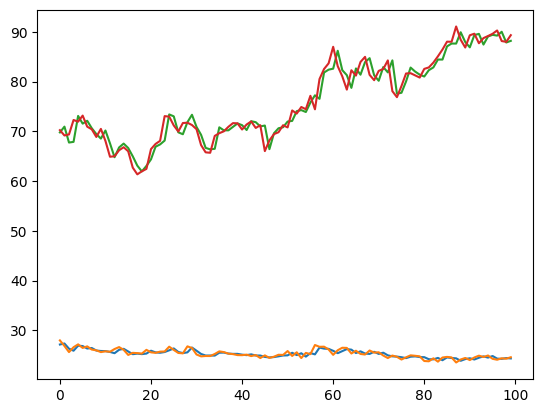

In [ ]:
# Prediction vs Actual graph using trained data for temperature and relative humidity
post_grutrain_processed_df = plot_predictions(gru_model, X_train, y_train)
post_grutrain_processed_df.to_csv('GRU Train temp & RH.csv')

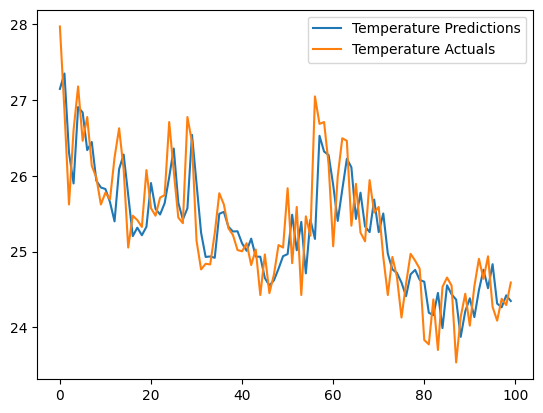

In [ ]:
# Prediction vs Actual graph using trained data for temperature only shown
start, end = 0, 100
plt.plot(post_grutrain_processed_df['Temperature Predictions'][start:end])
plt.plot(post_grutrain_processed_df['Temperature Actuals'][start:end])
plt.legend(['Temperature Predictions', 'Temperature Actuals'], loc='upper right')

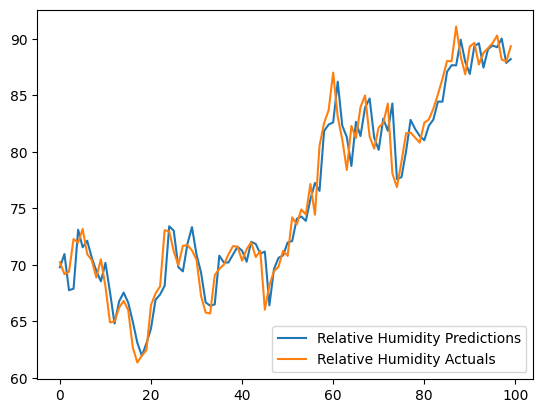

In [ ]:
# Prediction vs Actual graph using trained data for relative humidity only shown
plt.plot(post_grutrain_processed_df['Relative Humidity Predictions'][start:end])
plt.plot(post_grutrain_processed_df['Relative Humidity Actuals'][start:end])
plt.legend(['Relative Humidity Predictions', 'Relative Humidity Actuals'], loc='lower right')

241/241 [==============================] - 1s 3ms/step
temp before postprocess:[-1.5301765  -1.6227648  -1.384973   ... -0.2318933  -0.31089148
 -0.248914  ]
temp after postprocess:[23.897703 23.763441 24.108261 ... 25.780336 25.665781 25.755655]
temp before postprocess:[-1.84294224 -1.37664058 -0.95014516 ... -0.33599175 -0.30755872
 -0.72836754]
temp after postprocess:[23.44416246 24.12034416 24.73880302 ... 25.62938379 25.67061438
 25.06040163]


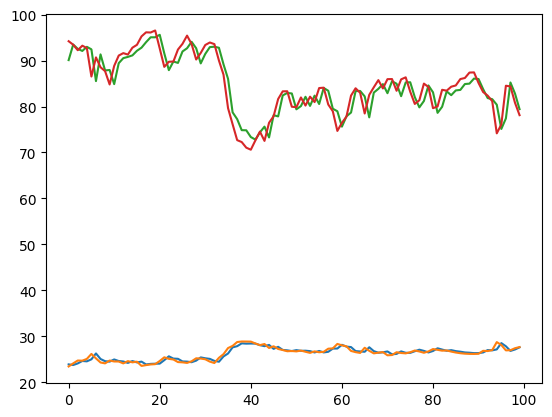

In [ ]:
# Prediction vs Actual graph using test data for temperature and relative humidity
post_grutest_processed_df = plot_predictions(gru_model, X_test, y_test)
post_grutest_processed_df.to_csv('GRU Test temp & RH.csv')

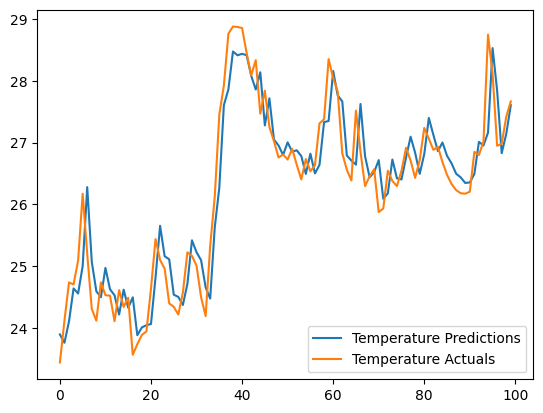

In [ ]:
# Prediction vs Actual graph using trained data for temperature only shown
start, end = 0, 100
plt.plot(post_grutest_processed_df['Temperature Predictions'][start:end])
plt.plot(post_grutest_processed_df['Temperature Actuals'][start:end])
plt.legend(['Temperature Predictions', 'Temperature Actuals'], loc='lower right')

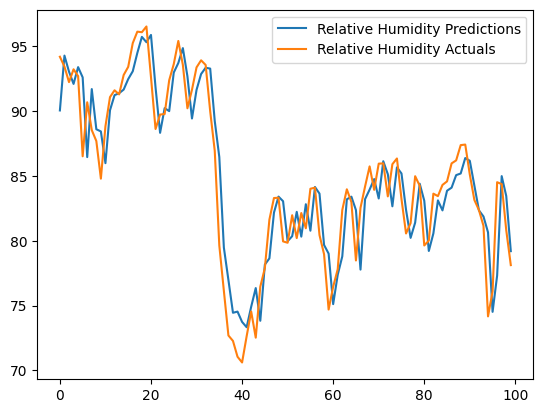

In [ ]:
# Prediction vs Actual graph using trained data for relative humidity only shown
plt.plot(post_conv1dtest_processed_df['Relative Humidity Predictions'][start:end])
plt.plot(post_conv1dtest_processed_df['Relative Humidity Actuals'][start:end])
plt.legend(['Relative Humidity Predictions', 'Relative Humidity Actuals'], loc='upper right')

## Metrics

In [ ]:
gru_temp_train_mae, gru_temp_train_mse, gru_temp_train_rmse, gru_temp_train_mape, gru_temp_train_r2 = calculate_metrics(post_grutrain_processed_df['Temperature Actuals'], post_grutrain_processed_df['Temperature Predictions'])
gru_temp_test_mae, gru_temp_test_mse, gru_temp_test_rmse, gru_temp_test_mape, gru_temp_test_r2 = calculate_metrics(post_grutest_processed_df['Temperature Actuals'], post_grutest_processed_df['Temperature Predictions'])

gru_rh_train_mae, gru_rh_train_mse, gru_rh_train_rmse, gru_rh_train_mape, gru_rh_train_r2 = calculate_metrics(post_grutrain_processed_df['Relative Humidity Actuals'], post_grutrain_processed_df['Relative Humidity Predictions'])
gru_rh_test_mae, gru_rh_test_mse, gru_rh_test_rmse, gru_rh_test_mape, gru_rh_test_r2 = calculate_metrics(post_grutest_processed_df['Relative Humidity Actuals'], post_grutest_processed_df['Relative Humidity Predictions'])

print("Metrics:\t\t\t\tMAE\t\t\tMSE\t\t\tRMSE\t\t\tMAPE\t\t\tR2\n")

print(f"Train Temperature Metrics:\t\t{gru_temp_train_mae}\t{gru_temp_train_mse}\t{gru_temp_train_rmse}\t{gru_temp_train_mape}\t{gru_temp_train_r2}")
print(f"Test Temperature Metrics:\t\t{gru_temp_test_mae}\t{gru_temp_test_mse}\t{gru_temp_test_rmse}\t{gru_temp_test_mape}\t{gru_temp_test_r2}")
print()
print(f"Train Relative Humidity Metrics:\t{gru_rh_train_mae}\t{gru_rh_train_mse}\t{gru_rh_train_rmse}\t{gru_rh_train_mape}\t{gru_rh_train_r2}")
print(f"Test Relative Humidity Metrics:\t\t{gru_rh_test_mae}\t{gru_rh_test_mse}\t{gru_rh_test_rmse}\t{gru_rh_test_mape}\t{gru_rh_test_r2}")


Metrics:				MAE			MSE			RMSE			MAPE			R2

Train Temperature Metrics:		0.3753885506352419	0.2327597440315013	0.48245180487951467	1.4763493965211365	0.6851497335934621
Test Temperature Metrics:		0.38819615110238287	0.24107415664234869	0.49099303115456605	1.4818771264152772	0.8744947290192586

Train Relative Humidity Metrics:	1.4318123132071507	3.522322887125641	1.8767852533323148	1.8879728012682868	0.946999915372281
Test Relative Humidity Metrics:		2.030200326758242	6.524868324966012	2.5543821806781404	2.4312417949425216	0.8422942359974765


## Evaluation

241/241 [==============================] - 1s 3ms/step - loss: 0.1591 - root_mean_squared_error: 0.3988
Test Loss of Gru Model: [0.15907491743564606, 0.3988419771194458]


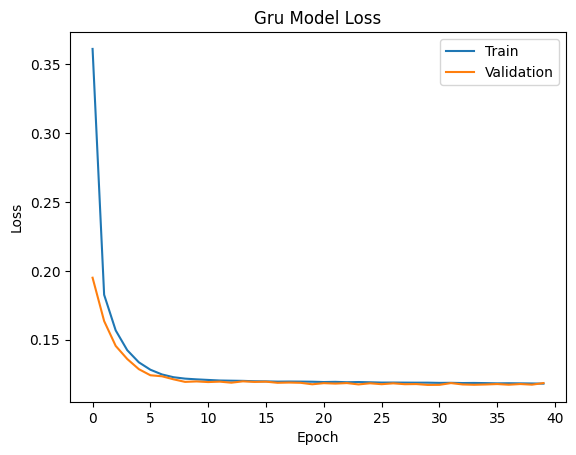

In [ ]:
# Evaluate the best model on the test set
gru_best_model = load_model('gru_model.keras')
gru_test_loss = gru_best_model.evaluate(X_test, y_test)
print("Test Loss of Gru Model:", gru_test_loss)

# Plot model training & validation loss values
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('Gru Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Results
## LSTM Metrics Summary
### Temperature Metrics

Train MAE: 0.383, MSE: 0.238, RMSE: 0.488, MAPE: 1.508, R2: 0.678

Test MAE: 0.386, MSE: 0.245, RMSE: 0.495, MAPE: 1.472, R2: 0.872

### Relative Humidity Metrics
Train MAE: 1.413, MSE: 3.454, RMSE: 1.858, MAPE: 1.861, R2: 0.948

Test MAE: 2.038, MSE: 6.552, RMSE: 2.560, MAPE: 2.447, R2: 0.842

### Test Loss
[0.158, 0.397]

---

## Conv1d Metrics Summary
### Temperature Metrics
Train MAE: 0.386, MSE: 0.251, RMSE: 0.501, MAPE: 1.518, R2: 0.660

Test MAE: 0.385, MSE: 0.244, RMSE: 0.494, MAPE: 1.466, R2: 0.873

### Relative Humidity Metrics
Train MAE: 1.417, MSE: 3.524, RMSE: 1.877, MAPE: 1.866, R2: 0.947

Test MAE: 2.088, MSE: 6.701, RMSE: 2.589, MAPE: 2.513, R2: 0.838

### Test Loss
[0.160, 0.400]

---

## GRU Metrics Summary
### Temperature Metrics
Train MAE: 0.381, MSE: 0.239, RMSE: 0.489, MAPE: 1.497, R2: 0.677

Test MAE: 0.383, MSE: 0.239, RMSE: 0.489, MAPE: 1.461, R2: 0.876

### Relative Humidity Metrics
Train MAE: 1.413, MSE: 3.466, RMSE: 1.862, MAPE: 1.862, R2: 0.948

Test MAE: 1.980, MSE: 6.450, RMSE: 2.540, MAPE: 2.384, R2: 0.844

### Test Loss
[0.160, 0.400]

---
# Interpretation

1. **Model Performance**

*Temperature Prediction Consistency*

Across all models, the performance metrics for temperature prediction are consistent, which suggests that the choice of model architecture might not significantly impact temperature prediction accuracy. However, subtle differences exist, with LSTM and Conv1d models slightly better than GRU, particularly on the test set.

*Relative Humidity Prediction Variability*

There is more variability in the performance metrics for relative humidity prediction. LSTM consistently performs better than Conv1d and GRU, indicating that its architecture might be better suited for capturing the complex patterns in relative humidity data.

2. **Generalization and Overfitting**
*Generalization Ability*

All 3 models show good generalization ability, as evidenced by the similarity in performance metrics between the train and test sets. This suggests that the models are not overfitting to the training data and are effectively capturing underlying patterns that generalize to unseen data.

*Potential Overfitting*

The performance metrics on the test set are slightly worse than those on the training set for all models. This indicates a certain degree of overfitting, which is arguably common in machine learning models. Further regularization techniques or hyperparameter tuning could potentially alleviate this issue.

3. **Model Selection Considerations**
*Complexity vs. Performance Trade-off*

LSTM tends to have a more complex architecture compared to Conv1d and GRU, which might result in better performance but could also require more computational resources during training and inference.

*Interpretability*

While LSTM and GRU models are based on recurrent neural networks (RNNs) and might be more interpretable due to their sequential nature, Conv1d models, based on convolutional neural networks (CNNs), might offer different insights due to their convolutional operations.

4. **Further Analysis and Optimization**
*Hyperparameter Tuning*

Fine-tuning hyperparameters such as learning rate, batch size, and network architecture could potentially improve model performance further. This iterative process involves experimenting with different configurations to find the optimal set of parameters for the given task and dataset.

In summary, while the presented models show promising results, further analysis, experimentation, and consideration of application-specific requirements are necessary to make informed decisions about model selection and optimization.

In [ ]:
# metrics_temp = pd.DataFrame({
#     "Model": ["LSTM Train Temperature", "LSTM Test Temperature", "Conv1d Train Temperature", "Conv1d Test Temperature", "GRU Train Temperature", "GRU Test Temperature"],
#     "MAE": [lstm_temp_train_mae, lstm_temp_test_mae, conv1d_temp_train_mae, conv1d_temp_test_mae, gru_temp_train_mae, gru_temp_test_mae],
#     "MSE": [lstm_temp_train_mse, lstm_temp_test_mse, conv1d_temp_train_mse, conv1d_temp_test_mse, gru_temp_train_mse, gru_temp_test_mse],
#     "RMSE": [lstm_temp_train_rmse, lstm_temp_test_rmse, conv1d_temp_train_rmse, conv1d_temp_test_rmse, gru_temp_train_rmse, gru_temp_test_rmse],
#     "MAPE": [lstm_temp_train_mape, lstm_temp_test_mape, conv1d_temp_train_mape, conv1d_temp_test_mape, gru_temp_train_mape, gru_temp_test_mape],
#     "R2 Score": [lstm_temp_train_r2, lstm_temp_test_r2, conv1d_temp_train_r2, conv1d_temp_test_r2, gru_temp_train_r2, gru_temp_test_r2],
# })

# metrics_rh = pd.DataFrame({
#     "Model": ["LSTM Train Relative Humidity", "LSTM Test Relative Humidity",  "Conv1d Train Relative Humidity", "Conv1d Test Relative Humidity", "GRU Train Relative Humidity", "GRU Test Relative Humidity"],
#     "MAE": [lstm_rh_train_mae, lstm_rh_test_mae, conv1d_rh_train_mae, conv1d_rh_test_mae, gru_rh_train_mae, gru_rh_test_mae],
#     "MSE": [lstm_rh_train_mse, lstm_rh_test_mse, conv1d_rh_train_mse, conv1d_rh_test_mse, gru_rh_train_mse, gru_rh_test_mse],
#     "RMSE": [lstm_rh_train_rmse, lstm_rh_test_rmse, conv1d_rh_train_rmse, conv1d_rh_test_rmse, gru_rh_train_rmse, gru_rh_test_rmse],
#     "MAPE": [lstm_rh_train_mape, lstm_rh_test_mape, conv1d_rh_train_mape, conv1d_rh_test_mape, gru_rh_train_mape, gru_rh_test_mape],
#     "R2 Score": [lstm_rh_train_r2, lstm_rh_test_r2, conv1d_rh_train_r2, conv1d_rh_test_r2, gru_rh_train_r2, gru_rh_test_r2],
# })


# metrics_temp.to_csv('metrics_temp.csv')
# metrics_rh.to_csv('metrics_rh.csv')